In [45]:
%reset -f

#  Re-import necessary packages after kernel reset
import numpy as np
import pandas as pd
from scipy.signal import savgol_filter
# import ace_tools as tools

def compute_vehicle_path(t, vx, steering_angle_rad, wheelbase=2.7):
    """
    Compute x, y positions and heading (psi) of the vehicle over time
    using a simple kinematic bicycle model.
    
    Args:
        t (np.ndarray): time vector
        vx (np.ndarray): longitudinal velocity (m/s)
        steering_angle_rad (np.ndarray): steering angle (radians)
        wheelbase (float): distance between front and rear axles (m)
    
    Returns:
        x, y, psi: np.ndarrays of positions and heading
    """
    x = np.zeros_like(t)
    y = np.zeros_like(t)
    psi = np.zeros_like(t)

    for i in range(1, len(t)):
        dt = t[i] - t[i - 1]
        delta = steering_angle_rad[i]
        psi[i] = psi[i - 1] + (vx[i] / wheelbase) * np.tan(delta) * dt
        x[i] = x[i - 1] + vx[i] * np.cos(psi[i]) * dt
        y[i] = y[i - 1] + vx[i] * np.sin(psi[i]) * dt

    return x, y, psi

In [46]:
# Define time
t = np.linspace(0, 20, 2001)  # 0 to 20 seconds, 0.01s timestep

# # Fix steering behavior: steering angle should return to 0 after the turning phase
# def create_delayed_stop_profile_fixed_steering(t, accel_val, brake_val, turn_angle_deg):
#     ax_profile = np.piecewise(
#         t,
#         [t < 4, (t >= 4) & (t < 8), (t >= 8) & (t < 19), t >= 19],
#         [accel_val, 0.0, brake_val, 0.0]
#     )
#     ax_smoothed = savgol_filter(ax_profile, window_length=151, polyorder=3)

#     # Steering only during a defined turn window (e.g., t = 8 to 12 s)
#     steering_profile = np.piecewise(
#         t,
#         [t < 8, (t >= 8) & (t < 12), t >= 12],
#         [0.0, np.deg2rad(turn_angle_deg), 0.0]
#     )
#     steering_smoothed = savgol_filter(steering_profile, window_length=151, polyorder=3)

#     vx = np.zeros_like(t)
#     for i in range(1, len(t)):
#         dt = t[i] - t[i - 1]
#         vx[i] = vx[i - 1] + 0.5 * (ax_smoothed[i] + ax_smoothed[i - 1]) * dt

#     return ax_smoothed, steering_smoothed, vx

def create_delayed_stop_profile_fixed_steering(t, accel_val, brake_val_placeholder, turn_angle_deg):
    vx_temp = np.zeros_like(t)
    ax_temp = np.zeros_like(t)
    
    # Initial acceleration and cruise
    for i in range(1, len(t)):
        dt = t[i] - t[i - 1]
        if t[i] < 4:
            ax_temp[i] = accel_val
        elif t[i] < 8:
            ax_temp[i] = 0.0
        elif t[i] < 19:
            ax_temp[i] = brake_val_placeholder
        else:
            # Compute required deceleration to reach 0 at t=20
            remaining_time = t[-1] - t[i-1]
            ax_temp[i] = -vx_temp[i-1] / remaining_time if remaining_time > 0 else 0.0

        vx_temp[i] = max(vx_temp[i - 1] + 0.5 * (ax_temp[i] + ax_temp[i - 1]) * dt, 0.0)

    ax_smoothed = savgol_filter(ax_temp, window_length=151, polyorder=3)

    # Steering only during a defined turn window (e.g., t = 8 to 12 s)
    steering_profile = np.piecewise(
        t,
        [t < 8, (t >= 8) & (t < 12), t >= 12],
        [0.0, np.deg2rad(turn_angle_deg), 0.0]
    )
    steering_smoothed = savgol_filter(steering_profile, window_length=151, polyorder=3)

    return ax_smoothed, steering_smoothed, vx_temp

# Recompute profiles with corrected steering logic
# ax_mild, steering_mild, vx_mild = create_delayed_stop_profile_fixed_steering(t, accel_val=3.0, brake_val=-1.5, turn_angle_deg=3)
# ax_aggr, steering_aggr, vx_aggr = create_delayed_stop_profile_fixed_steering(t, accel_val=6.0, brake_val=-2.5, turn_angle_deg=8)

ax_mild, steering_mild, vx_mild = create_delayed_stop_profile_fixed_steering(t, accel_val=3.0, brake_val_placeholder=-1.5, turn_angle_deg=3)
ax_aggr, steering_aggr, vx_aggr = create_delayed_stop_profile_fixed_steering(t, accel_val=6.0, brake_val_placeholder=-2.5, turn_angle_deg=5)


# Recompute positions
x_mild, y_mild, psi_mild = compute_vehicle_path(t, vx_mild, steering_mild)
x_aggr, y_aggr, psi_aggr = compute_vehicle_path(t, vx_aggr, steering_aggr)

# Update DataFrames
df_mild = pd.DataFrame({
    'time': t, 'vx': vx_mild, 'ax': ax_mild, 'steering_angle_rad': steering_mild,
    'x': x_mild, 'y': y_mild, 'psi_rad': psi_mild
})

df_aggressive = pd.DataFrame({
    'time': t, 'vx': vx_aggr, 'ax': ax_aggr, 'steering_angle_rad': steering_aggr,
    'x': x_aggr, 'y': y_aggr, 'psi_rad': psi_aggr
})

# Numerical derivative of psi_rad w.r.t. time (yaw rate)
df_mild['yaw_rate_rad_s'] = np.gradient(df_mild['psi_rad'], df_mild['time'])
df_aggressive['yaw_rate_rad_s'] = np.gradient(df_aggressive['psi_rad'], df_aggressive['time'])


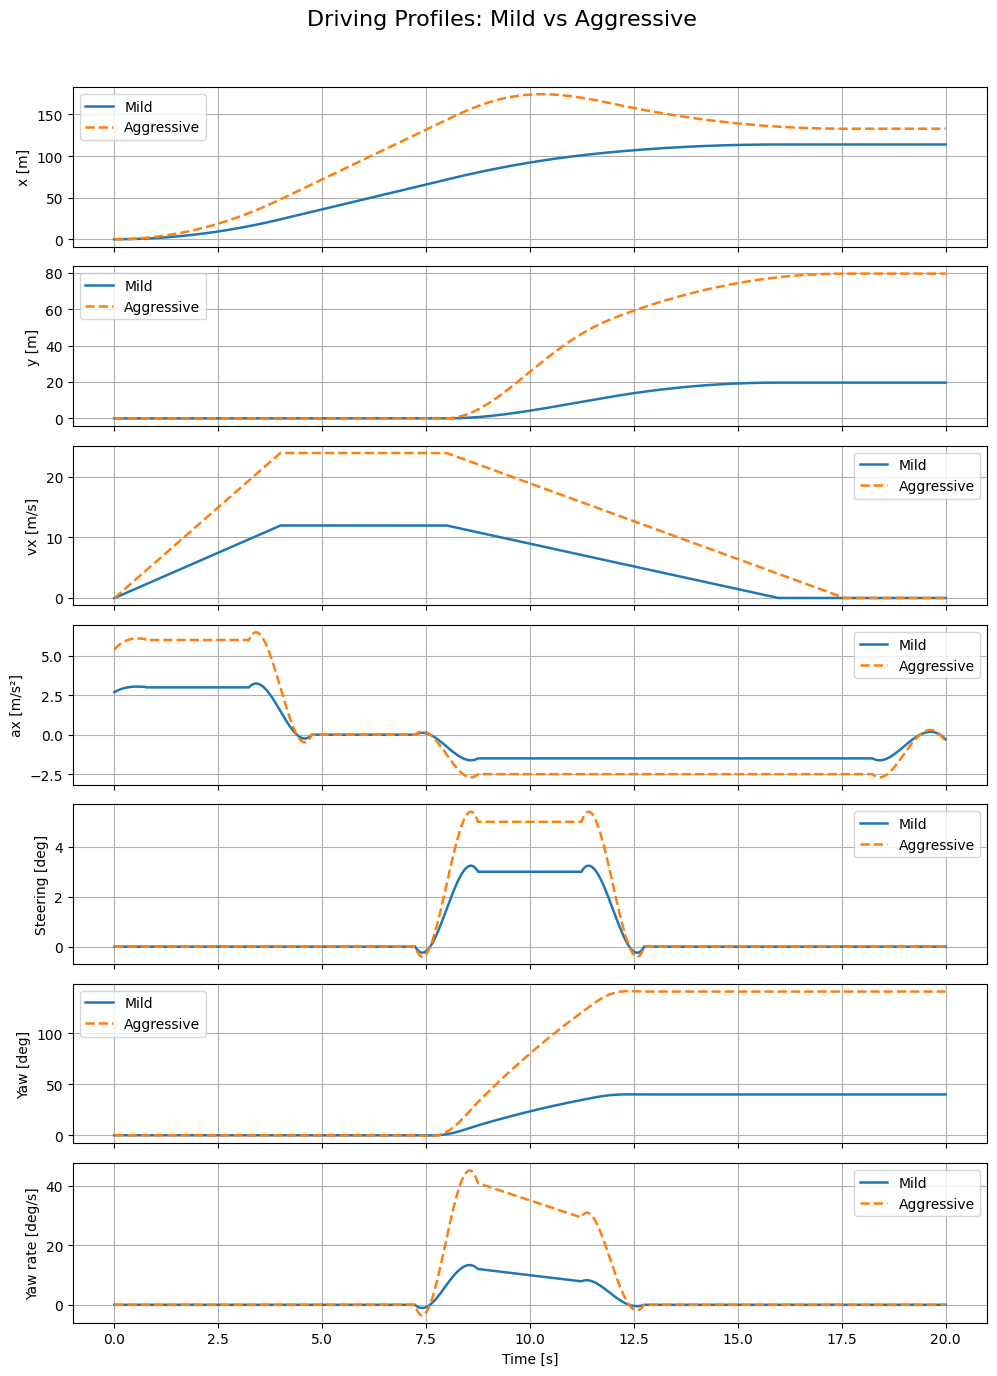

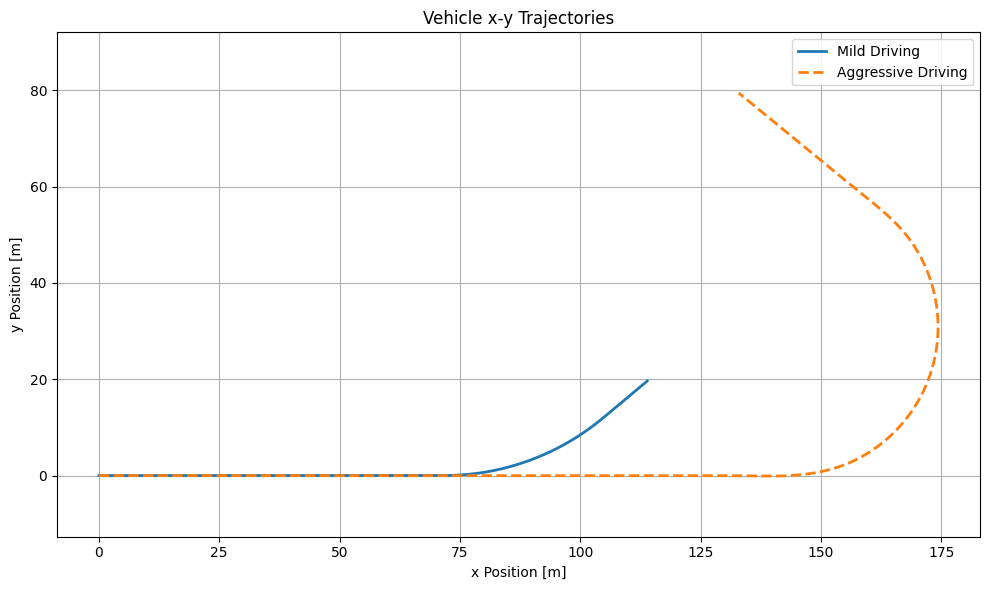

In [53]:
import matplotlib.pyplot as plt
# # Plotting
# fig, axs = plt.subplots(7, 2, figsize=(14, 12), sharex=True)
# fig.suptitle('Driving Profile', fontsize=16)

# # Mild
# axs[0, 0].plot(df_mild['time'], df_mild['x'])
# axs[0, 0].set_title('Mild Driving')
# axs[0, 0].set_ylabel('x [m]')
# axs[0, 0].grid(True)

# axs[1, 0].plot(df_mild['time'], df_mild['y'])
# axs[1, 0].set_ylabel('y [m]')
# axs[1, 0].grid(True)

# axs[2, 0].plot(df_mild['time'], df_mild['vx'])
# axs[2, 0].set_ylabel('vx [m/s]')
# axs[2, 0].grid(True)

# axs[3, 0].plot(df_mild['time'], df_mild['ax'], color='g')
# axs[3, 0].set_ylabel('ax [m/s²]')
# axs[3, 0].grid(True)

# axs[4, 0].plot(df_mild['time'], np.rad2deg(df_mild['steering_angle_rad']), color='r')
# axs[4, 0].set_ylabel('Steering angle [deg]')
# axs[4, 0].grid(True)

# axs[5, 0].plot(df_mild['time'], np.rad2deg(df_mild['psi_rad']), color='r')
# axs[5, 0].set_ylabel('Yaw [deg]')
# axs[5, 0].grid(True)

# axs[6, 0].plot(df_mild['time'], np.rad2deg(df_mild['yaw_rate_rad_s']), color='r')
# axs[6, 0].set_ylabel('Yaw velocity [deg/s]')
# axs[6, 0].grid(True)
# axs[6, 0].set_xlabel('Time [s]')

# # Aggressive
# axs[0, 1].plot(df_aggressive['time'], df_aggressive['x'])
# axs[0, 1].set_title('Aggressive Driving')
# axs[0, 1].set_ylabel('x [m]')
# axs[0, 1].grid(True)

# axs[1, 1].plot(df_aggressive['time'], df_aggressive['y'])
# axs[1, 1].set_ylabel('y [m]')
# axs[1, 1].grid(True)

# axs[2, 1].plot(df_aggressive['time'], df_aggressive['vx'])
# axs[2, 1].set_ylabel('vx [m/s]')
# axs[2, 1].grid(True)

# axs[3, 1].plot(df_aggressive['time'], df_aggressive['ax'], color='g')
# axs[3, 1].set_ylabel('ax [m/s²]')
# axs[3, 1].grid(True)

# axs[4, 1].plot(df_aggressive['time'], np.rad2deg(df_aggressive['steering_angle_rad']), color='r')
# axs[4, 1].set_ylabel('Steering [deg]')
# axs[4, 1].grid(True)

# axs[5, 1].plot(df_aggressive['time'], np.rad2deg(df_aggressive['psi_rad']), color='r')
# axs[5, 1].set_ylabel('Yaw [deg]')
# axs[5, 1].grid(True)

# axs[6, 1].plot(df_aggressive['time'], np.rad2deg(df_aggressive['yaw_rate_rad_s']), color='r')
# axs[6, 1].set_ylabel('Yaw velocity [deg/s]')
# axs[6, 1].grid(True)
# axs[6, 1].set_xlabel('Time [s]')

# plt.tight_layout()
# plt.show()

# Plotting
fig, axs = plt.subplots(7, 1, figsize=(10, 14), sharex=True)
fig.suptitle('Driving Profiles: Mild vs Aggressive', fontsize=16)

# Row 0: x
axs[0].plot(df_mild['time'], df_mild['x'], label='Mild', linewidth=1.8)
axs[0].plot(df_aggressive['time'], df_aggressive['x'], label='Aggressive', linestyle='--', linewidth=1.8)
axs[0].set_ylabel('x [m]')
axs[0].grid(True)
axs[0].legend()

# Row 1: y
axs[1].plot(df_mild['time'], df_mild['y'], label='Mild', linewidth=1.8)
axs[1].plot(df_aggressive['time'], df_aggressive['y'], label='Aggressive', linestyle='--', linewidth=1.8)
axs[1].set_ylabel('y [m]')
axs[1].grid(True)
axs[1].legend()

# Row 2: vx
axs[2].plot(df_mild['time'], df_mild['vx'], label='Mild', linewidth=1.8)
axs[2].plot(df_aggressive['time'], df_aggressive['vx'], label='Aggressive', linestyle='--', linewidth=1.8)
axs[2].set_ylabel('vx [m/s]')
axs[2].grid(True)
axs[2].legend()

# Row 3: ax
axs[3].plot(df_mild['time'], df_mild['ax'], label='Mild', linewidth=1.8)
axs[3].plot(df_aggressive['time'], df_aggressive['ax'], label='Aggressive', linestyle='--', linewidth=1.8)
axs[3].set_ylabel('ax [m/s²]')
axs[3].grid(True)
axs[3].legend()

# Row 4: steering angle
axs[4].plot(df_mild['time'], np.rad2deg(df_mild['steering_angle_rad']), label='Mild', linewidth=1.8)
axs[4].plot(df_aggressive['time'], np.rad2deg(df_aggressive['steering_angle_rad']), label='Aggressive', linestyle='--', linewidth=1.8)
axs[4].set_ylabel('Steering [deg]')
axs[4].grid(True)
axs[4].legend()

# Row 5: yaw
axs[5].plot(df_mild['time'], np.rad2deg(df_mild['psi_rad']), label='Mild', linewidth=1.8)
axs[5].plot(df_aggressive['time'], np.rad2deg(df_aggressive['psi_rad']), label='Aggressive', linestyle='--', linewidth=1.8)
axs[5].set_ylabel('Yaw [deg]')
axs[5].grid(True)
axs[5].legend()

# Row 6: yaw rate
axs[6].plot(df_mild['time'], np.rad2deg(df_mild['yaw_rate_rad_s']), label='Mild', linewidth=1.8)
axs[6].plot(df_aggressive['time'], np.rad2deg(df_aggressive['yaw_rate_rad_s']), label='Aggressive', linestyle='--', linewidth=1.8)
axs[6].set_ylabel('Yaw rate [deg/s]')
axs[6].set_xlabel('Time [s]')
axs[6].grid(True)
axs[6].legend()

plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout to include suptitle
plt.show()

# Create a new figure for x-y trajectory comparison
plt.figure(figsize=(10, 6))
plt.plot(df_mild['x'], df_mild['y'], label='Mild Driving', linewidth=2)
plt.plot(df_aggressive['x'], df_aggressive['y'], label='Aggressive Driving', linestyle='--', linewidth=2)

plt.title('Vehicle x-y Trajectories')
plt.xlabel('x Position [m]')
plt.ylabel('y Position [m]')
plt.axis('equal')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
